### From Scratch

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [29]:
def f(x):
    #random function
    return 3*x**2 - 4*x + 5
f(3.0)

20.0

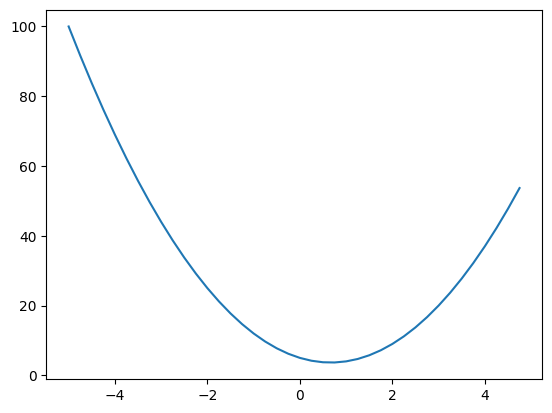

In [30]:
xs = np.arange(-5,5,0.25) #linear steps
ys = f(xs)

plt.plot(xs,ys)

In [31]:
#Recap: What is derivative? Lets derive!
h = 0.00000001
x = 3.0
L = (f(x+h) - f(x))/h
L

14.00000009255109

In [32]:
#More complex
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [33]:

h = 0.000001

d1 = a*b + c
a += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.9999969999999996
slope -3.000000000419334


In [34]:
## NN Data Structure

class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 #assume no affect.
        self._prev = set(_children)
        #backprop
        self._backward = lambda: None 
        self._op = _op
        self.label = label
    
    def __repr__(self): #print 'nicer' expression
        return f"Value(data={self.data})"
    
    def __rmul__(self,other):
        return self * other
    
    def __radd__(self,other):
        return self + other
    
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)    
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out
    
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,),'tanh')

        #tanh(x)^2 
        def _backward():
            self.grad += (1 - t**2) * out.grad      
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [35]:
#visualization
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
        
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir':'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular 'record' node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}"% (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot




In [36]:
L.grad = 1  # Given
d.grad = -2 # dL/df = -2
f.grad = 4  # dL/df = 4 
c.grad = -2 # dL/dd * dd/dc = -2 * 1
e.grad = -2 # dL/dd * dd/dc = -2 * 1

b.grad = -4 # dL/db = dL/dd * dd/de * de/db = -2 * 1 * 2 = -4 
a.grad = 6 # dL/da = dL/dd * dd/de * de/da = -2 * 1 * -3 = 6

In [37]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


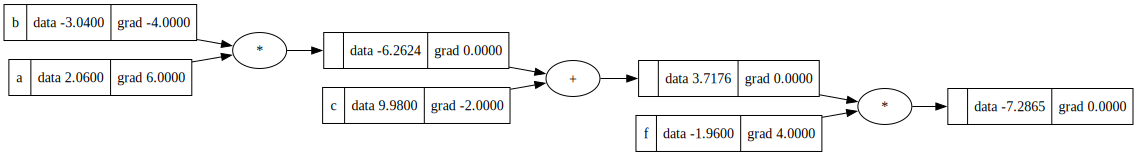

In [38]:
#Visualizing Forward Pass
draw_dot(L)

In [39]:
#Backpropagation:
#Derivative of L respective to all nodes!
def lol():
    h = 0.0001

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()


0.0


### Talk about Neurons!

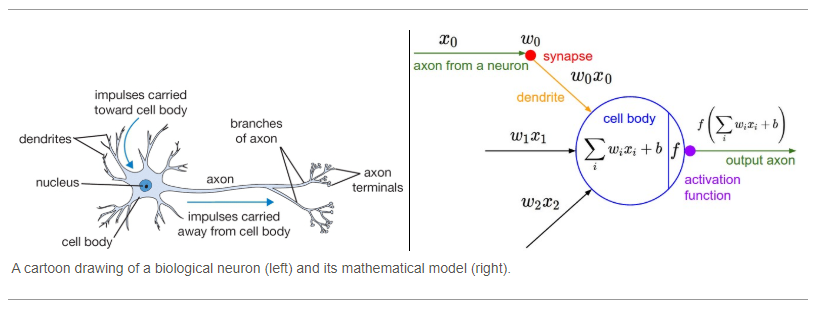

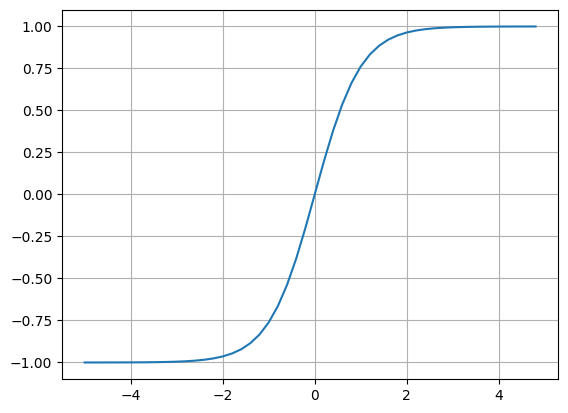

In [40]:
#activation function

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [41]:
#Ex. # inputs of x1, x2:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias of the neuron
b = Value(6.8813735870195432, label = 'b')

#w1x1 + w2x2 + b:

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

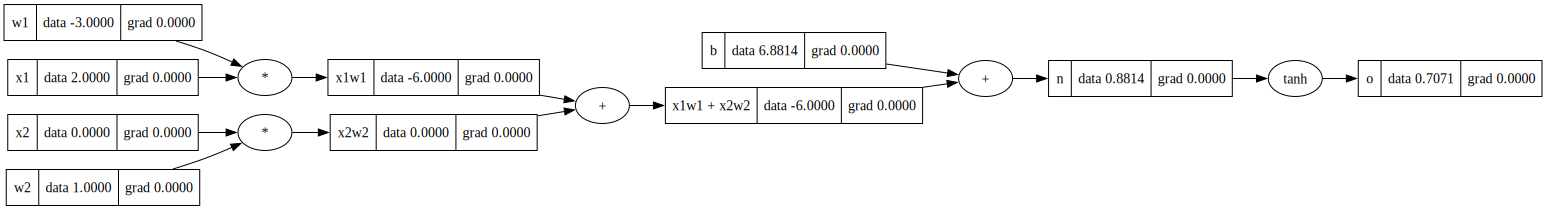

In [42]:
draw_dot(o)

In [43]:
#_backward in order.
o.grad = 1.0
o._backward()

n._backward()

b._backward()
x1w1x2w2._backward()

x2w2._backward()
x1w1._backward()

In [44]:
# OR
o.backward()

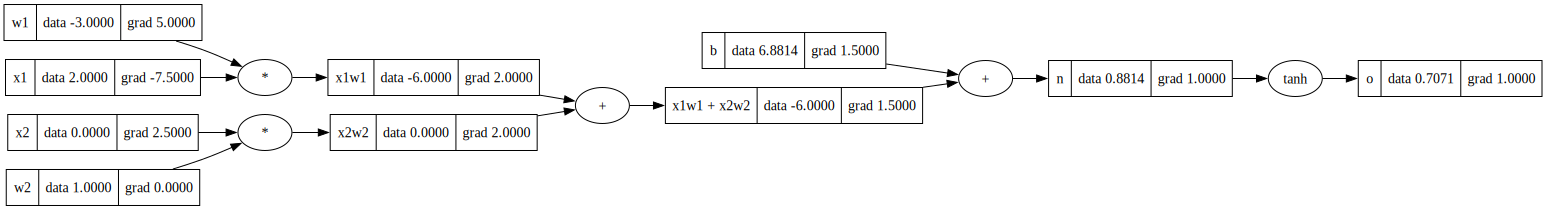

In [45]:
draw_dot(o)

### Automatic Backprop using topo sort!
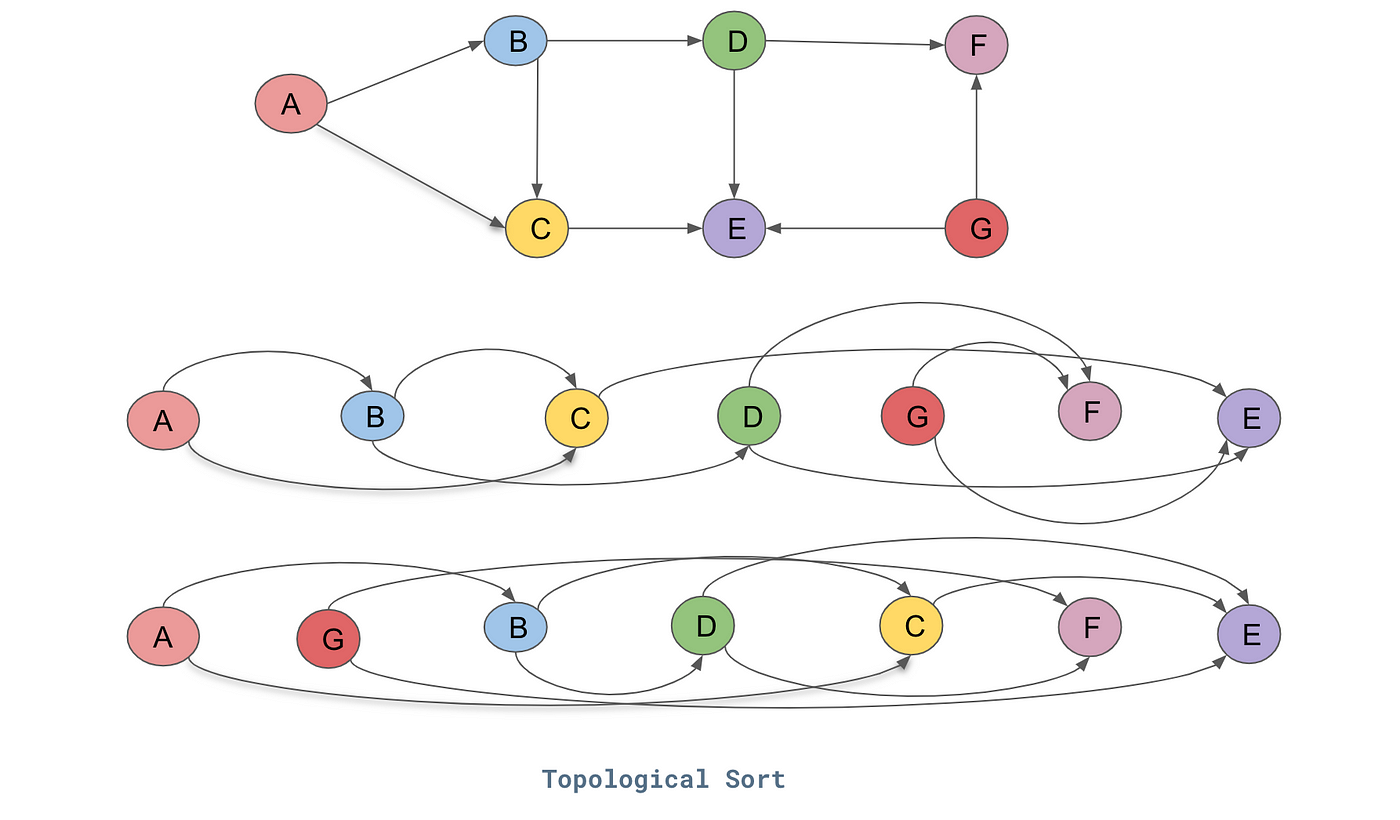

In [46]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [47]:
o.grad = 1.0 #do/do = 1

# do/dn = 1 - tanh(x)^2 = 1 - o^2
n.grad = 1 - o.data**2

# do/db = do/dn * dn/db = (1 - o.data**2) * 1
b.grad = n.grad
# do/d(x1w1x2w2) = do/dn * dn/d(x1w1x2w2) = (1 - o.data**2) * 1
x1w1x2w2.grad = n.grad

x2w2.grad = n.grad
x1w1.grad = n.grad

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

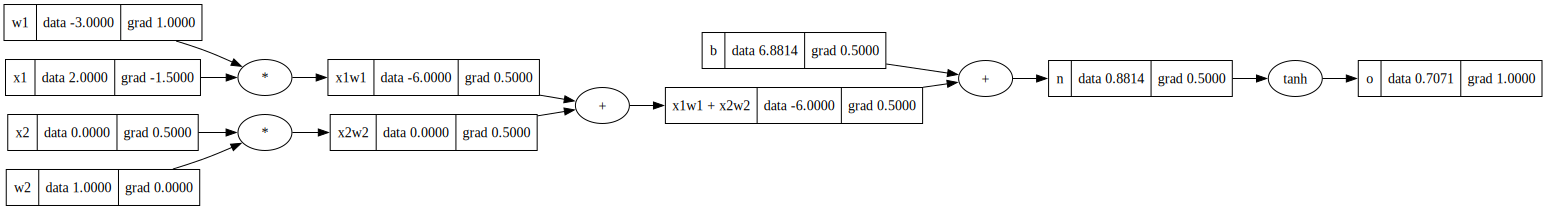

In [48]:
draw_dot(o)

In [49]:
### Fixing Bugs of add (what if b = a + a?)
#accumulate the grad! (b._backward = a._backward + a._backward)


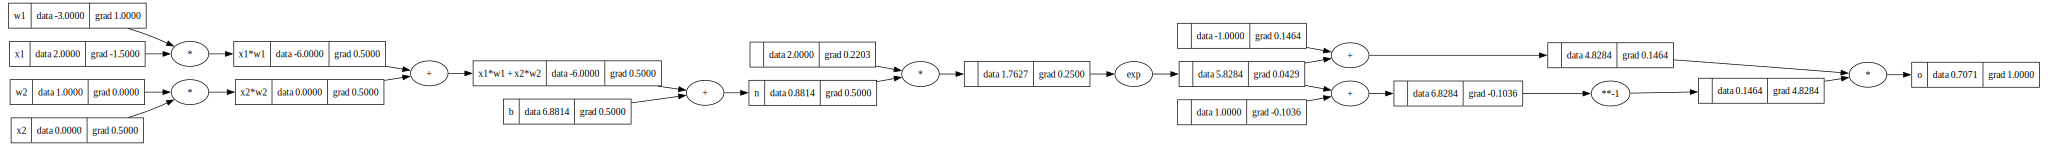

In [50]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [51]:
#comparing to pytorch
import torch


In [52]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


***
### Creating Neuron Classes
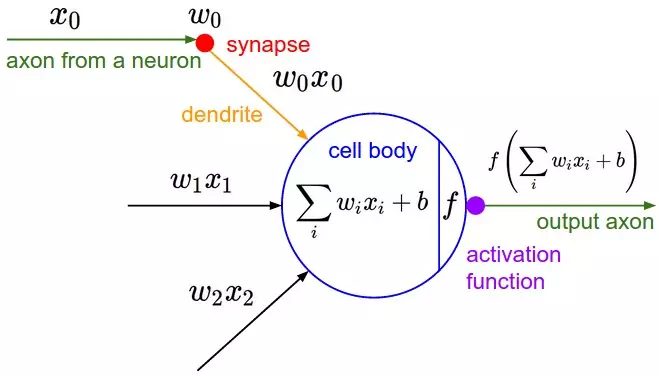
***

In [136]:
from numpy import random

class Neuron:
    def __init__(self, nin): #nin = number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: #multi-layer perceptrons

    def __init__ (self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
                       
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [161]:
x = [2.0,3.0,-1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.27420816053732144)

In [162]:
n.parameters()

[Value(data=0.5462840240248046),
 Value(data=0.6201673585959935),
 Value(data=0.8078916321073373),
 Value(data=-0.08054309210276722),
 Value(data=-0.2977786079875884),
 Value(data=-0.623243757922517),
 Value(data=0.6293079777707034),
 Value(data=0.56817116357134),
 Value(data=-0.38278935323643126),
 Value(data=0.5925345386389935),
 Value(data=-0.6079473918406475),
 Value(data=-0.32881948160553054),
 Value(data=0.34698075795717),
 Value(data=0.8303914985665255),
 Value(data=-0.02048604931056497),
 Value(data=-0.2986113402114765),
 Value(data=0.8376558601044441),
 Value(data=-0.3352830706834209),
 Value(data=-0.9022396979164047),
 Value(data=-0.20606855055472661),
 Value(data=0.49801975243904795),
 Value(data=-0.1301398689371822),
 Value(data=0.3415586311322245),
 Value(data=-0.012479118927186228),
 Value(data=0.7725807878636197),
 Value(data=0.5361426047486004),
 Value(data=-0.7054300543447638),
 Value(data=0.16195560164796063),
 Value(data=0.2136408445354745),
 Value(data=-0.9531295692

In [163]:
# Example:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
# How to 'tune'? Calculate Loss, then correct it!


In [140]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
loss

Value(data=1.8559628706357332)

In [141]:
loss.backward()

In [143]:
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)

0.1949790317424795
0.22267992511062373


In [144]:
# How to 'correct' it? Adjust it by a 'small amount' aka Gradient Descent

for p in n.parameters():
    p.data += -0.01 * p.grad 


In [145]:
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)

#forward feedback
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
loss

0.1949790317424795
0.22073013479319895


In [156]:
#Loss is decreased! So do it in loops!
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred)) #calculate loss
loss.backward() #calculate gradients of the parameters respect to loss 

for p in n.parameters(): #correct it
    p.data += -0.01 * p.grad #from the gradient, try to decrease the loss by a small stepsize aka learning rate.

print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)
print(ypred)
print(n.parameters())

-0.5578982650873051
0.24898613394372068
[Value(data=0.9785068420984263), Value(data=-0.938215018204276), Value(data=-0.9753896083719842), Value(data=0.9592970982862055)]
[Value(data=0.24898613394372068), Value(data=-0.6654204712219155), Value(data=1.2480302342188907), Value(data=0.6041519232700157), Value(data=-0.2726305752141916), Value(data=-0.05819432536751669), Value(data=-0.3107139320870204), Value(data=0.913795059275359), Value(data=-0.6304275229821458), Value(data=-0.0018301432310161674), Value(data=0.27787144000547487), Value(data=-0.7927643864286259), Value(data=0.9646100240108195), Value(data=0.1755292483306375), Value(data=0.05855962281991186), Value(data=-0.3611785971649048), Value(data=1.1023326069710497), Value(data=0.2745742634714471), Value(data=-0.09674870108495207), Value(data=-0.7629498392012549), Value(data=0.043314559635467334), Value(data=0.37802897663555723), Value(data=-0.21606232532621047), Value(data=-0.8547274437748285), Value(data=-0.42522317203930865), Valu

In [164]:
for k in range(20):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))

    #backward pass
    #zero grad first! if not. then will give massive step size! bigger slope then usual.
    for p in n.parameters(): #correct it
        p.grad = 0 #zero it out so it doesnt add/minus previous grad!
    loss.backward()

    #update
    for p in n.parameters(): #correct it
        p.data += -0.01 * p.grad #from the gradient, try to decrease the loss by a small stepsize aka learning rate.

    print(k, loss.data)

0 4.367895527023007
1 4.147120417686986
2 3.9516150337951657
3 3.774981934948137
4 3.610669022314143
5 3.4528565275875964
6 3.2968468019378916
7 3.139143101625703
8 2.9774154785639397
9 2.810464387545315
10 2.638204538125545
11 2.461632563602822
12 2.2827176607458286
13 2.1041678360483065
14 1.9290723885577468
15 1.7604818242913622
16 1.6010235587195452
17 1.4526411453723662
18 1.3164949776954256
19 1.1930063629907806
